### To use CNN's for inferring the Zernike polynomials given a set of focused and defocused images of the quiet Sun

The main steps are:

1- Generate the training data

2- Labelling the training data

3- Prepare the CNN architecture to use

4- Train and validate

5- Test the Model

## Generation of training data

I will use MURAM simulations of a quiet Sun region and convolve it with different PSF's corresponding to different combinations of Zernike polynomials (excluding the first 3 values).
Then I will fix a value of defocus of half a lambda to generate the aberrated defocused images. 
The simulations would be rescaled to the pixel size of PHI and therefore becoming very small so no need to slice the original frame.
Pixel size will depend on distance. As a next step, I will use different pixel sizes but for now I will fix the distance to 1 AU.

In [17]:
%run ./helper_functions.ipynb


In [10]:
# Load the synthesized scene and resample it to HRT pixel size

In [18]:
import numpy as np
import pyfits
import os
from scipy.interpolate import interpolate

import matplotlib.pyplot as plt

In [19]:
p_masi_file = '/home/jovyan/PD_analysis/muram_4x4.fits'
masi = pyfits.getdata(p_masi_file)
foc = Resample(masi,1.,18.)
foc_noise = add_noise(foc[0],SNR=20)

In [4]:
foc[1]

(128, 128)

In [20]:
## optical system parameters of HRT
p_masi = os.path.join('.','masi_data/')
D = 140
lam = 617.3*10**(-6)
pix = 0.5
f = 4125.3                  
ap = 10

In [23]:
num_data = 15000
poly = 34
shape = foc[1]
Zernikes = np.zeros((num_data,poly))
training_data = np.zeros((num_data,shape[0],shape[0],2))
#f = open('zernikes_training','w') 

In [24]:
for i in range(num_data):
 Z = np.random.uniform(low=-0.5,high=0.5,size=poly)#np.random.rand(poly)
 Zernikes[i] = Z
 #f.write(str(Zernikes[i])+'\n')
 #foc = Resample(masi,1.,18.)
 #foc_noise = add_noise(foc[0],SNR=100)
 foc_psf = degrade(foc_noise,Z,D,lam,pix)
 defoc = add_defocus(foc_psf,D,lam,pix,defocus=0.5)
 training_data[i,:,:,0] = foc_psf/foc_psf.max()
 training_data[i,:,:,1]= defoc/defoc.max()
 #savefits(foc_psf,p_masi+'foc_z_'+str(i)+'.fits')
 #savefits(defoc,p_masi+'defoc_z_'+str(i)+'.fits')
 #fig,ax = plt.subplots(1,2,figsize=(12,10))
 #ax[0].imshow(foc_psf,cmap='gray')
 #ax[1].imshow(defoc,cmap='gray')
#f.close()
 

/tmp/ipykernel_757/2938205748.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(rpupil)
/tmp/ipykernel_757/2938205748.py:70: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  abbe_z = np.zeros((len(abb

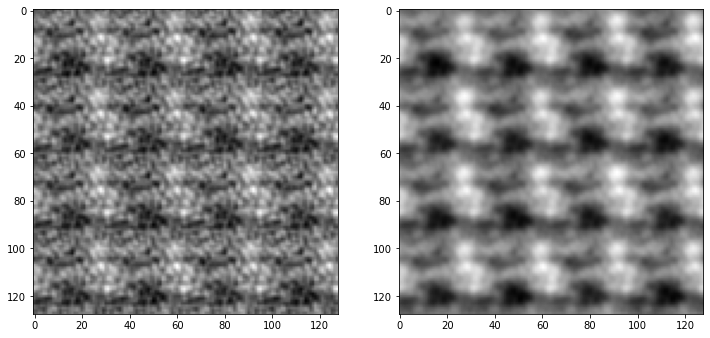

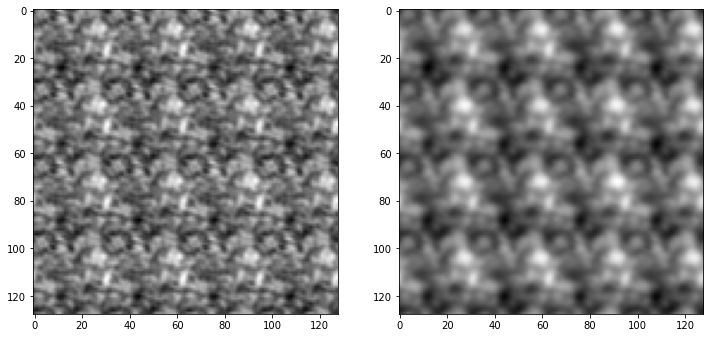

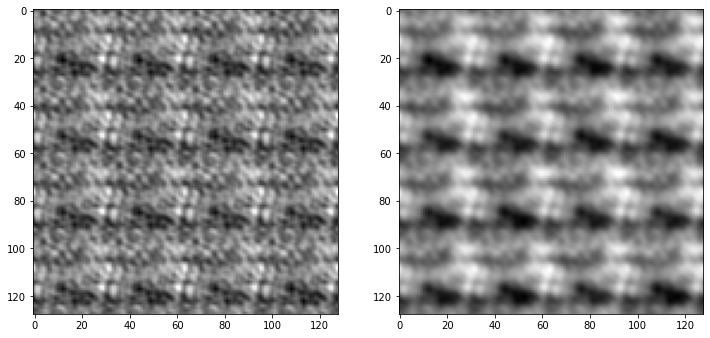

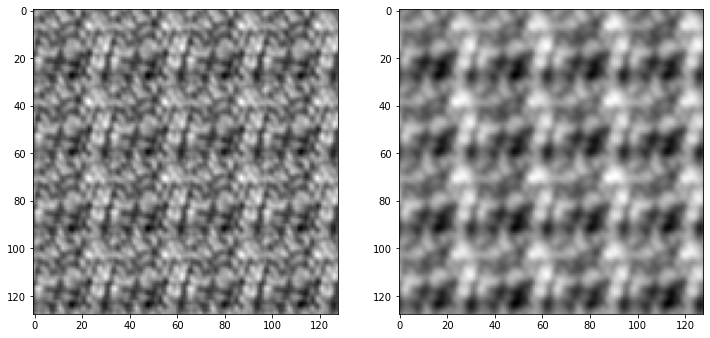

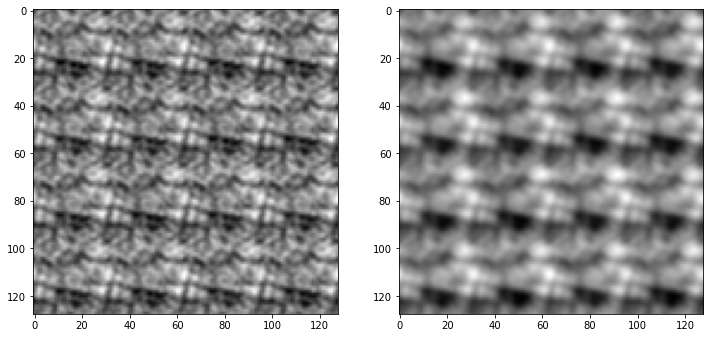

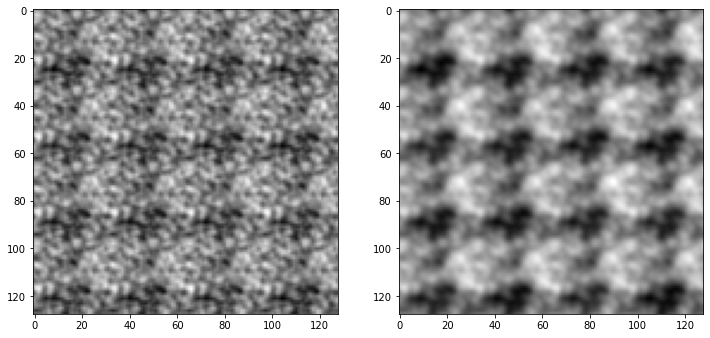

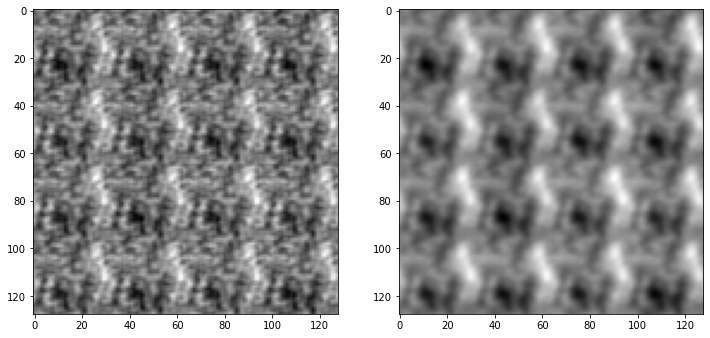

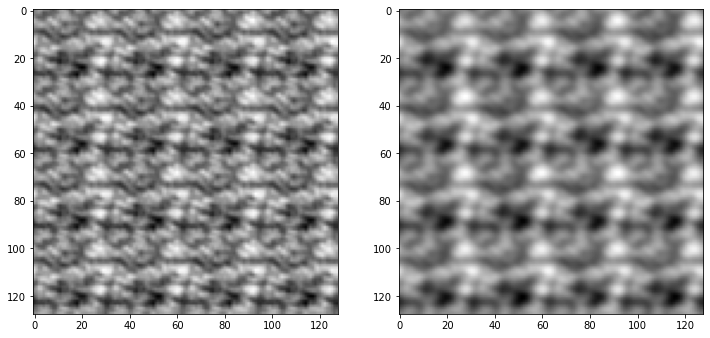

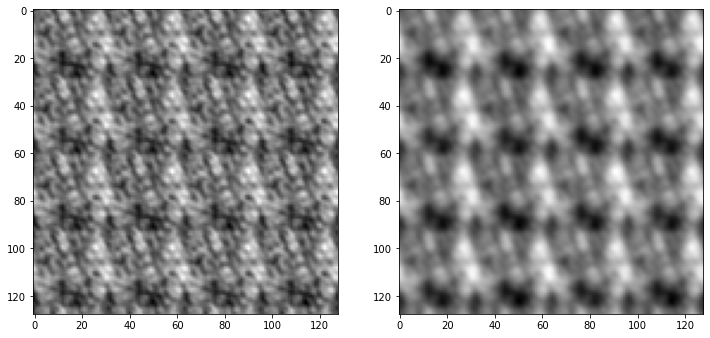

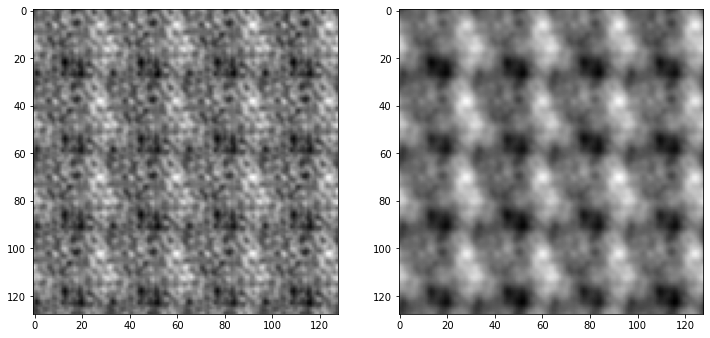

In [25]:
for i in range(10):
    fig,ax = plt.subplots(1,2,figsize=(12,10))
    ax[0].imshow(training_data[i,:,:,0],cmap='gray')
    ax[1].imshow(training_data[i,:,:,1],cmap='gray')

In [10]:
## to open the saved data:
'''
num_data = 1000
poly = 10
Zernikes = np.zeros((num_data,poly))
training_data = np.zeros((num_data,128,128,2))
list = os.listdir(p_masi)
for i in range(num_data):
    training_data[i,:,:,0] = pyfits.getdata(p_masi+'foc_z_'+str(i)+'.fits')
    training_data[i,:,:,1] = pyfits.getdata(p_masi+'defoc_z_'+str(i)+'.fits')
'''    

In [26]:
training_data.shape

(15000, 128, 128, 2)

In [27]:
Zernikes.shape

(15000, 34)

In [28]:
def conv2d_bn(x, nb_filter, nb_row, nb_col,
              padding='same', strides=(1, 1),
              name=None):
    """
    Utility function to apply conv + BN for Inception V3.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    bn_axis = 3
    x = Convolution2D(nb_filter, (nb_row, nb_col),strides=strides,
                      activation='relu',padding=padding)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name)(x)
    return x
  
def inception_v3_model(img_rows, img_cols, channel=2):
    """
    Inception-V3 Model for Keras
    Model Schema is based on 
    https://github.com/fchollet/deep-learning-models/blob/master/inception_v3.py
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of class labels for our classification task
    """
    #channel_axis = 1
    #channel_axis = 2
    img_input = Input(shape=(img_rows, img_cols, channel))
    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
  
    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
  
    
    
      # mixed 0, 1, 2: 35 x 35 x 256
    for i in range(3):
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)
  
        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
  
        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
#        x = merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
#                  mode='concat', concat_axis=channel_axis,
#                  name='mixed' + str(i))
        x = layers.concatenate([branch1x1, branch5x5,
               branch3x3dbl, branch_pool],axis=-1, name='mixed' + str(i))
    
        
    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')
  
    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3,
                               strides=(2, 2), padding='valid')
  
    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
#    x = merge([branch3x3, branch3x3dbl, branch_pool],
#              mode='concat', concat_axis=channel_axis,
#              name='mixed3')
    x = layers.concatenate([branch3x3, branch3x3dbl,branch_pool],
                           axis=-1, name='mixed3') 
    
    
      # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
  
    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
#    x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
#              mode='concat', concat_axis=channel_axis,
#              name='mixed4')
  
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                           axis=-1,name='mixed4')
    

    
      # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)
 
        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)
  
        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
  
        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
#        x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
#                  mode='concat', concat_axis=channel_axis,
#                  name='mixed' + str(5 + i))
        x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                               axis=-1,name='mixed' + str(5 + i))
    
    
    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)
  
    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)
  
    branch7x7dbl = conv2d_bn(x, 160, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
  
    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
#    x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
#              mode='concat', concat_axis=channel_axis,
#              name='mixed7')
    
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                           axis=-1,name='mixed7')
    
    
    
  
    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')
  
    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3,
                            strides=(2, 2), padding='valid')
  
    branch_pool = AveragePooling2D((3, 3), strides=(2, 2))(x)
#    x = merge([branch3x3, branch7x7x3, branch_pool],
#              mode='concat', concat_axis=channel_axis,
#              name='mixed8')
  
    x = layers.concatenate([branch3x3, branch7x7x3, branch_pool],
                    axis=-1,name='mixed8')
    
    
    
    
    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)
  
        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
#        branch3x3 = merge([branch3x3_1, branch3x3_2],
#                          mode='concat', concat_axis=channel_axis,
#                          name='mixed9_' + str(i))
#        
        branch3x3 = layers.concatenate([branch3x3_1, branch3x3_2],axis=-1,
                                       name='mixed9_' + str(i))
  
        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
#        branch3x3dbl = merge([branch3x3dbl_1, branch3x3dbl_2],
#                             mode='concat', concat_axis=channel_axis)
        
        branch3x3dbl = layers.concatenate([branch3x3dbl_1, branch3x3dbl_2],
                                          axis=-1)
        
  
        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
#        x = merge([branch1x1, branch3x3, branch3x3dbl, branch_pool],
#                  mode='concat', concat_axis=channel_axis,
#                  name='mixed' + str(9 + i))
  
    x = layers.concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool],
                           axis=-1,name='mixed' + str(9 + i))
    
    
    
    # Fully Connected Softmax Layer
    #x_fc = AveragePooling2D((6, 6), strides=(6, 6), name='avg_pool')(x)
    #x_fc = Flatten(name='flatten')(x_fc)
    x_fc = Flatten(name='flatten')(x)
    x_fc = layers.Dropout(0.3)(x_fc)
    x_fc = Dense(output_width, activation='linear',name='predictions')(x_fc)
    # Create model
    model = Model(img_input, x_fc)
    
    # Print model summary
    model.summary()
    
    return model 

In [29]:
img_rows=shape[0]
img_cols=shape[0]
channel = 2
batch_size=32
epochs=6
validation_steps = num_data//batch_size
output_width = poly

In [30]:
from keras.models import Sequential
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.models import Model
from keras import backend as K
from keras import Model,layers,optimizers,Input
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow import keras



In [14]:
## normalization of the training data
'''
for i in range(num_data):
    max_val = training_data[i,:,:,:].max()
    training_data[i,:,:,:] = training_data[i,:,:,:]/max_val
'''

'\nfor i in range(num_data):\n    max_val = training_data[i,:,:,:].max()\n    training_data[i,:,:,:] = training_data[i,:,:,:]/max_val\n'

In [31]:

from sklearn import metrics
from sklearn.model_selection import train_test_split

test_size=0.15
print('Training (%0.2f %%) and validation (%0.2f %%) split..' % (
    (1-test_size)*100,(test_size)*100))

X_train, X_test, y_train, y_test = train_test_split(
        training_data,
        Zernikes, 
        test_size=test_size)

Training (85.00 %) and validation (15.00 %) split..


In [32]:
from tensorflow.keras.layers import BatchNormalization
model = inception_v3_model(img_rows, img_cols, channel)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 63, 63, 32)   608         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 63, 63, 32)  128         ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [33]:
#model.compile(optimizer=adam,loss='mse',metrics=[tf.keras.metrics.MeanAbsoluteError()])
#model.compile(loss='mean_absolute_error',  optimizer=SGD(lr=0.01, momentum=0.9),  metrics=['mse'])
adam=keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam,loss='mse',metrics=['mae'])

In [ ]:
import time
start = time.time()
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    steps_per_epoch=num_data//batch_size,
                    validation_steps=num_data//batch_size,
                    verbose = 1,shuffle=False)  


Epoch 1/6
468/468 [==============================] - 932s 2s/step - loss: 1.3625 - mae: 0.7500 - val_loss: 8.7498 - val_mae: 2.5000
Epoch 2/6
373/468 [======================>.......] - ETA: 1:54 - loss: 0.6146 - mae: 0.5502

In [74]:
duration = time.time() - start
print('{0:6.0f} minutes to fit'.format(duration/60.))

    35 minutes to fit


In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']


In [76]:
val_loss

[0.35427916049957275]

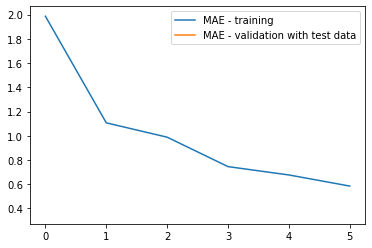

In [77]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='MAE - training')
pyplot.plot(history.history['val_loss'], label='MAE - validation with test data')
pyplot.legend()

In [78]:
model.save('Run_10000_epochs_6_Z_32.h5')

In [79]:
_,val_mse = model.evaluate(X_test,y_test,verbose=1)

24/24 [==============================] - 16s 656ms/step - loss: 0.4509 - mae: 0.4042


In [80]:
print('MAE from validation: %10.2f'%(val_mse))

MAE from validation:       0.40


In [8]:
#model = keras.models.load_model('./Run_5000_epochs_6.h5')


2022-02-23 13:52:55.867145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-23 13:52:55.867201: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-23 13:52:55.867235: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ef865399d802): /proc/driver/nvidia/version does not exist
2022-02-23 13:52:55.867511: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [81]:
## testing on one example

test= np.random.uniform(low=-1,high=1,size=poly)#np.random.rand(poly)
val = np.zeros((1,shape[0],shape[0],2))
foc_psf = degrade(foc_noise,test,D,lam,pix)
defoc = add_defocus(foc_psf,D,lam,pix,defocus=0.5)
test_foc = foc_psf/foc_psf.max()
test_defoc = defoc/defoc.max()
val[:,:,:,0] = test_foc
val[:,:,:,1] = test_defoc
test_pred = model.predict(val)

/tmp/ipykernel_482/2938205748.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(rpupil)
/tmp/ipykernel_482/2938205748.py:70: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  abbe_z = np.zeros((len(abb

In [82]:
test, RMS_WF(test)

(array([ 0.18130915, -0.27339859,  0.52453439,  0.8187992 ,  0.16365003,
        -0.25389766, -0.12844883,  0.75419972, -0.17986531, -0.94240316,
        -0.46844161, -0.60892678, -0.18463063,  0.30820033, -0.09954425,
         0.93894864, -0.36532453, -0.22680976, -0.78763888, -0.91128577,
        -0.83575272,  0.10737289, -0.03874323,  0.63023772, -0.34287718,
         0.35317339, -0.01927698, -0.28092697, -0.87316065,  0.03700383,
         0.2887559 , -0.15882789,  0.80047132,  0.08565867]),
 2.112360584906915)

In [83]:
test_pred, RMS_WF(test_pred)

(array([[ 5.2468020e-01,  6.5985543e-01, -1.2509817e-01,  1.0543470e+00,
          6.6833586e-01,  8.7931967e-01,  1.4544415e-01,  1.2074388e+00,
          6.9241869e-01,  8.5877079e-01,  6.5132886e-01,  2.3715010e-01,
          1.0332495e+00,  1.1010377e+00,  8.5982418e-01,  3.7024468e-01,
          3.2529601e-01,  4.7417197e-01,  7.4295513e-04,  6.5967894e-01,
          4.5437375e-01,  6.4855003e-01,  5.0796515e-01,  2.2484989e-01,
          2.6906225e-01,  8.6287409e-02,  7.6851153e-01,  2.0762357e-01,
          4.6762019e-01,  1.1297959e+00,  6.8526840e-01,  5.2109349e-01,
          6.4960939e-01,  5.7713079e-01]], dtype=float32),
 1.6334040804881944)

## creating new data and testing the model


In [93]:
num_data = 100
poly = 32
Zernikes = np.zeros((num_data,poly))
test_data = np.zeros((num_data,shape[0],shape[0],2))
for i in range(num_data):
 Z = np.random.uniform(low=0,high=1,size=poly)#np.random.rand(poly)
 Zernikes[i] = Z
 #foc = Resample(masi,1.,18.)
 #foc_noise = add_noise(foc[0],SNR=100)
 foc_psf = degrade(foc_noise,Z,D,lam,pix)
 defoc = add_defocus(foc_psf,D,lam,pix,defocus=0.5)
 test_data[i,:,:,0] = foc_psf/foc_psf.max()
 test_data[i,:,:,1]= defoc/defoc.max()
 
 

/tmp/ipykernel_482/2938205748.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(rpupil)
/tmp/ipykernel_482/2938205748.py:70: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  abbe_z = np.zeros((len(abb

In [94]:
y_pred = model.predict(test_data)

In [95]:
y_pred[40], Zernikes[40]

(array([ 0.63961273,  0.74542326, -0.15022114,  0.472819  ,  0.46282127,
         0.7295072 , -0.03883314,  0.79817504,  1.0256593 ,  0.92170775,
         0.501808  , -0.03235284,  0.7939834 ,  1.0394068 ,  0.64934486,
         0.41953462,  0.09465958,  0.6960779 ,  0.06412545,  0.7365498 ,
         0.68936974,  0.49271244,  0.6377377 ,  0.55071944,  0.3090743 ,
         0.42772028,  0.7640113 ,  0.56337255,  0.34615195,  0.56667167,
         0.7801198 ,  0.46225855,  0.7669186 ,  0.29152668], dtype=float32),
 array([0.5046577 , 0.84842798, 0.44342932, 0.18846698, 0.76341241,
        0.92178315, 0.88541182, 0.47965569, 0.09701892, 0.97745811,
        0.36149263, 0.72269043, 0.86157415, 0.11528047, 0.89221822,
        0.76843572, 0.2264338 , 0.27303106, 0.48451583, 0.40501495,
        0.86452365, 0.19328136, 0.14169884, 0.60103044, 0.67879906,
        0.37840695, 0.8951869 , 0.26716834, 0.5493146 , 0.67268648,
        0.70842824, 0.46795742]))

/tmp/ipykernel_482/2938205748.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(rpupil)
/tmp/ipykernel_482/2938205748.py:70: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  abbe_z = np.zeros((len(abb

0.04476348694934582 0.025914508595495534
0.024279052862506142 0.02485140276634307
0.025565382844147395 0.020769067298644035
0.040712140498721267 0.023361024288384182
0.03064868463746006 0.051620587086870444
0.03510652288848406 0.02053325130940658
0.043164574427389905 0.017447766104253293
0.042785340492341756 0.018309066154655038
0.029777485401975896 0.047442901298470584
0.04730644655095766 0.045944033772636506
0.03747299113574017 0.0430608880494295
0.030959793510855035 0.04531008192691469
0.05128265541578473 0.025266096752557816
0.04537304360455942 0.018548333410322946
0.0406613646169338 0.016549359188630028
0.0433314245059462 0.012934830044482346
0.033895473520904454 0.041398506597738506
0.02628442600761077 0.04567023543680293
0.04289328481086231 0.01774306850747719
0.0383020392263591 0.026472284737964584
0.03043623223245889 0.02480871445878527
0.02688755640978006 0.01761801308197955
0.045038346615369214 0.023243901717148983


/tmp/ipykernel_482/3090748409.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2,figsize=(8,8))


0.039473224869051554 0.022450165406401743
0.05208288591278402 0.026246522690846135
0.03761930910498722 0.03438859151485333
0.0332573096424842 0.027804849806212485
0.03989496946727412 0.022686770046359904
0.03473749857760659 0.04310646429134424
0.03213115996410371 0.025340639806788696
0.03542387216253829 0.022281654270677662
0.029134133377339045 0.021024373246291642
0.026402993791082758 0.04095263806598629
0.03170839472919366 0.024357832948678836
0.034399164078746804 0.030614508921295025
0.04268479265519936 0.02611367023156948
0.03393101535092402 0.023599755189384557
0.03037749574930852 0.023497300583296143
0.02901708749464972 0.02476236593002115
0.03311492851433085 0.024191112440702257


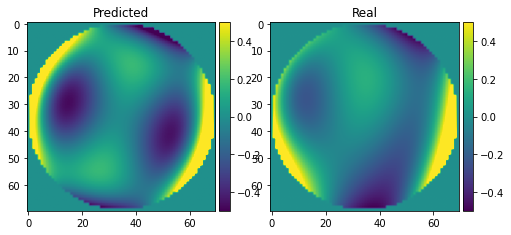

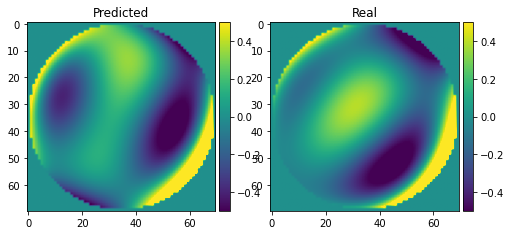

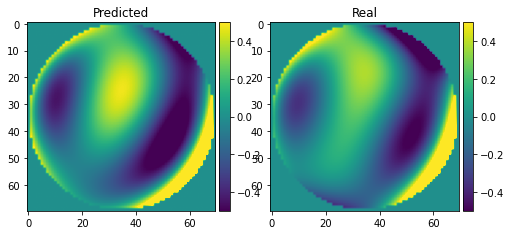

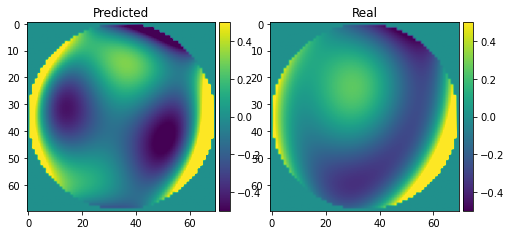

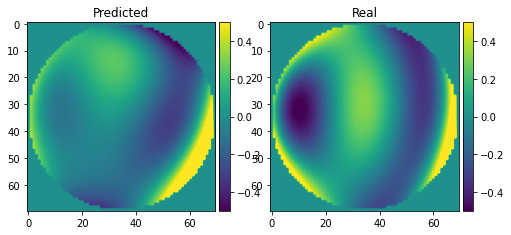

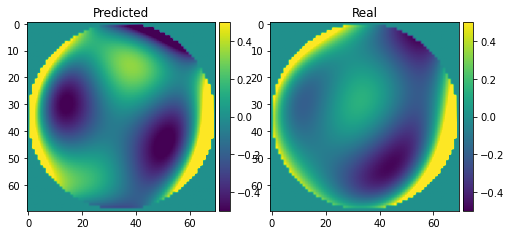

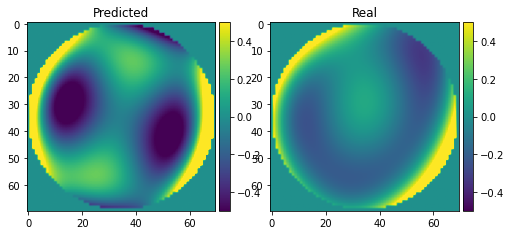

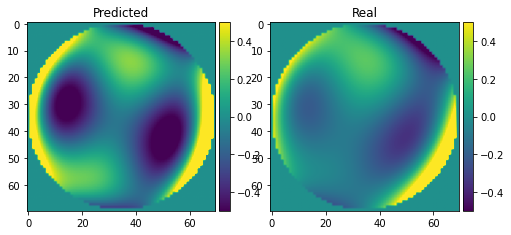

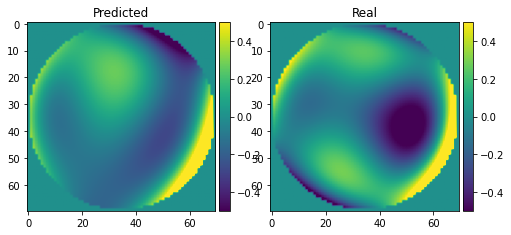

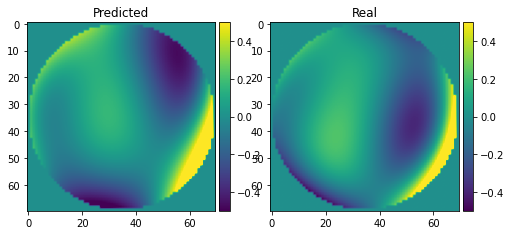

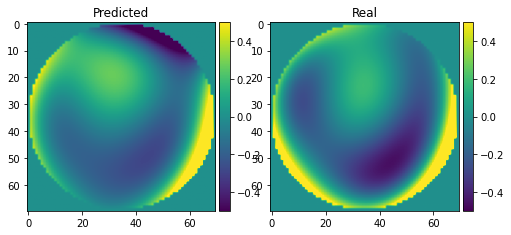

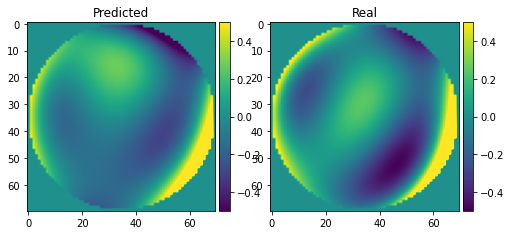

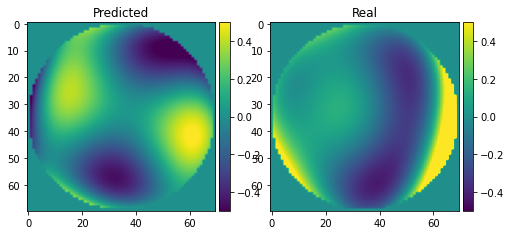

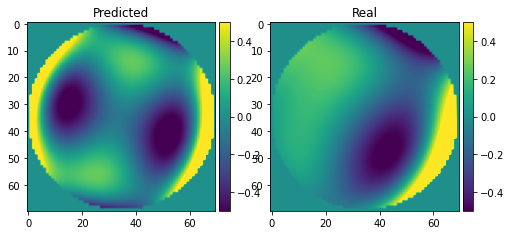

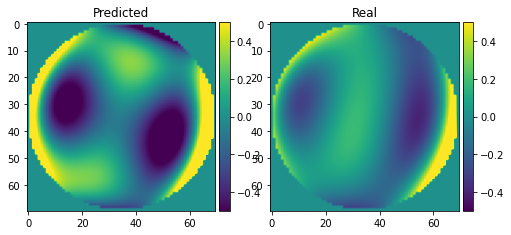

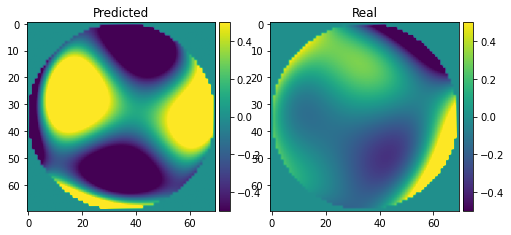

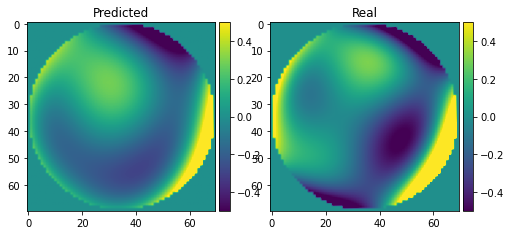

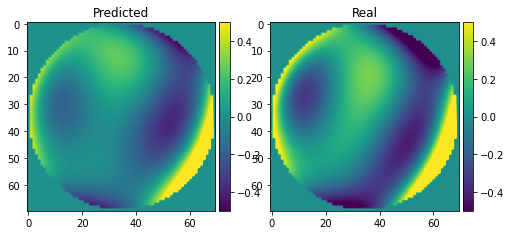

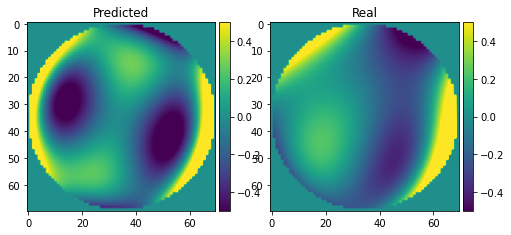

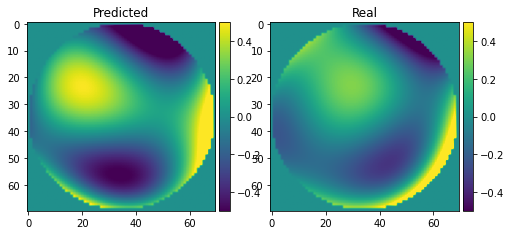

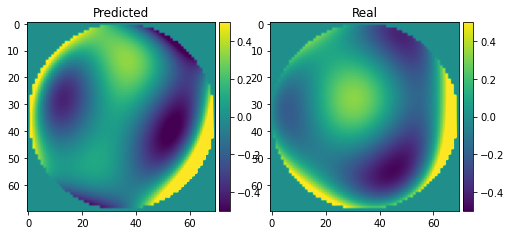

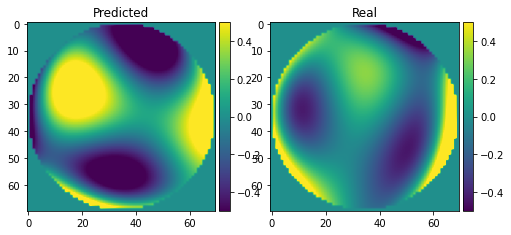

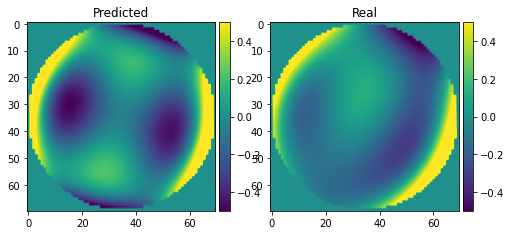

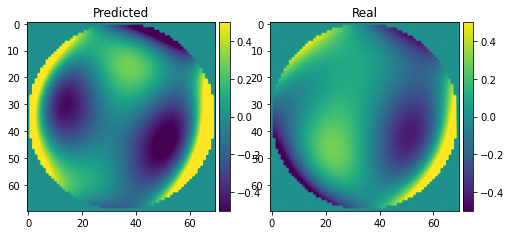

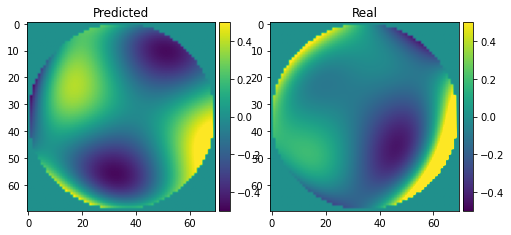

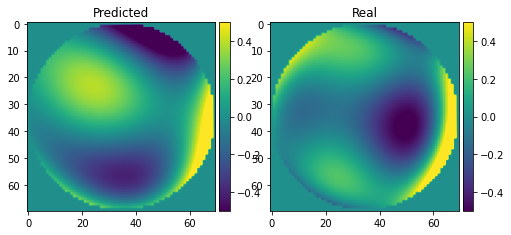

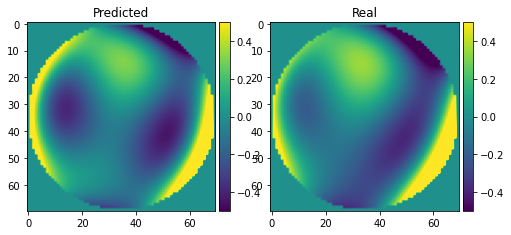

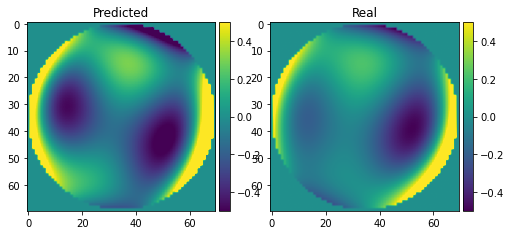

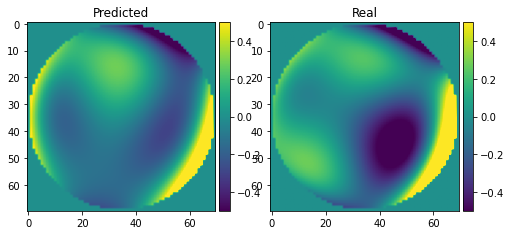

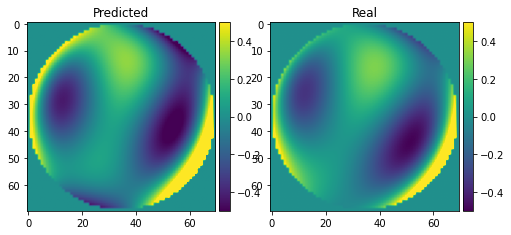

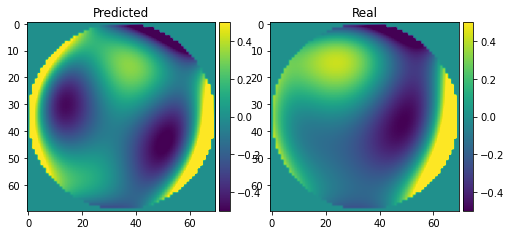

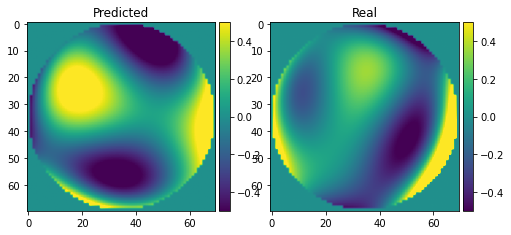

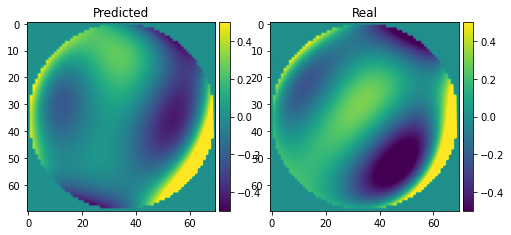

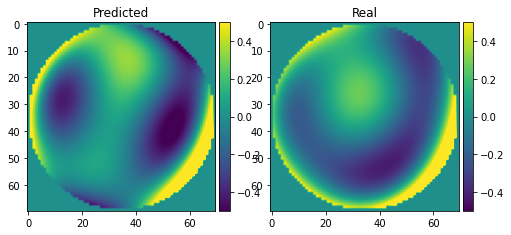

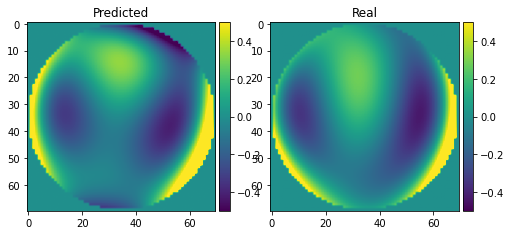

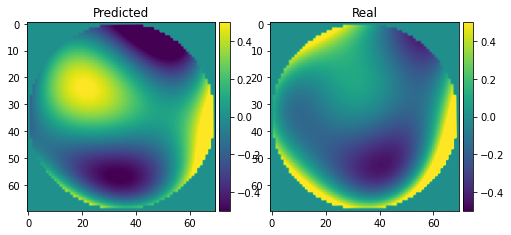

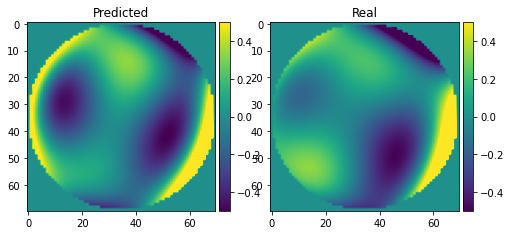

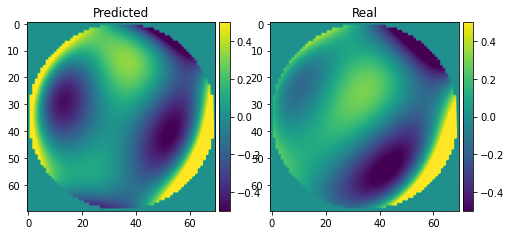

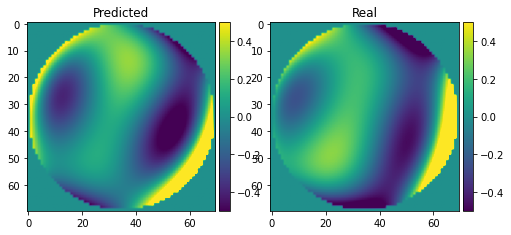

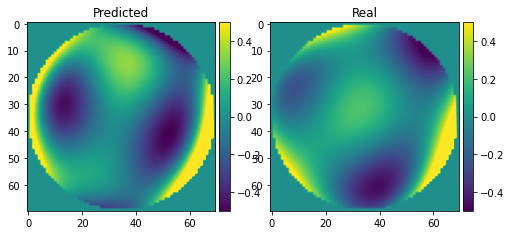

In [97]:
for i in range(40):
    pred_zernikes = y_pred[i]
    real_zernikes = Zernikes[i]
    foc_psf_pred = degrade(foc_noise,pred_zernikes,D,lam,pix)
    defoc_pred = add_defocus(foc_psf,D,lam,pix,defocus=0.5)  #print (pred_zernikes)
    
    foc_psf = test_data[i,:,:,0]
    defoc = test_data[i,:,:,1]
    print (RMS_cont(foc_psf), RMS_cont(foc_psf_pred))
    pred_WF = create_WF(pred_zernikes,D,lam,pix,img_rows)
    real_WF = create_WF(real_zernikes,D,lam,pix,img_rows)
    fig, ax = plt.subplots(1,2,figsize=(8,8))
    im=ax[0].imshow(pred_WF/(2*np.pi),vmin=-0.5,vmax=0.5)#(foc_psf_pred)#
    ax[0].set_title('Predicted')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right',pad=0.05,size=0.15) #size is the width of the color bar and pad is the fraction of the new axis
    plt.colorbar(im,cax=cax)

    im2=ax[1].imshow(real_WF/(2*np.pi),vmin=-0.5,vmax=0.5)#((foc_psf)#
    ax[1].set_title('Real')
    divider2 = make_axes_locatable(ax[1])
    cax2 = divider2.append_axes('right',pad=0.05,size=0.15) #size is the width of the color bar and pad is the fraction of the new axis
    plt.colorbar(im2,cax=cax2)



In [40]:
accuracy = 100*(1/len(y_pred)**2)*(np.sum(y_pred-y_test)**2)

In [41]:
accuracy

47508.06637479973

In [117]:
all_val_mae.shape

(1,)

In [95]:
(pred_WF/(2*np.pi)).max()

0.5797756143311593